In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-account-fraud-dataset-neurips-2022/Base.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant IV.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant V.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant I.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant III.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant II.csv


In [2]:
import pandas as pd

# Import the datasets
base = pd.read_csv('/kaggle/input/bank-account-fraud-dataset-neurips-2022/Base.csv')
variant_1 = pd.read_csv('/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant I.csv')
variant_2 = pd.read_csv('/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant II.csv')
variant_3 = pd.read_csv('/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant III.csv')
variant_4 = pd.read_csv('/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant IV.csv')
variant_5 = pd.read_csv('/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant V.csv')

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

datasets = {
    "Base": base,
    "Variant I": variant_1,
    "Variant II": variant_2,
    "Variant III": variant_3,
    "Variant IV": variant_4,
    "Variant V": variant_5,
}

train_test_data = {}

# Process each dataset
for name, data_raw in datasets.items():
    print(f"Processing Dataset: {name}")
    
    # Check column names

    # Verify if target column exists
    target_variable = 'fraud_bool'
    if target_variable not in data_raw.columns:
        raise ValueError(f"'{target_variable}' column not found in {name} dataset. Please check the column name.")

    # Verify that 'month' column exists
    if 'month' not in data_raw.columns:
        raise ValueError(f"'month' column not found in {name} dataset. Please check the column name.")

    # Split the data into train and test based on the "month" feature
    train_data = data_raw[data_raw['month'].between(0, 5)]
    test_data = data_raw[data_raw['month'].between(6, 7)]
    
    # Drop the "month" feature from train and test sets
    train_data = train_data.drop(columns=['month'])
    test_data = test_data.drop(columns=['month'])
    
    # Reset index
    train_data.reset_index(drop=True, inplace=True)
    test_data.reset_index(drop=True, inplace=True)
    
    # Separate features and target variable
    X_train = train_data.drop(columns=[target_variable])
    y_train = train_data[target_variable]
    X_test = test_data.drop(columns=[target_variable])
    y_test = test_data[target_variable]

    # Correctly identify numerical and categorical features after dropping 'month'
    numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Check feature columns before pre-processing
    
    # Update ColumnTransformer with correct feature names
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(sparse_output=False, drop='first'), categorical_features)
        ]
    )
    
    # Apply the ColumnTransformer
    try:
        X_train_transformed = preprocessor.fit_transform(X_train)
        X_test_transformed = preprocessor.transform(X_test)
    except KeyError as e:
        print(f"KeyError: {e}")
        print(f"Numerical Features: {numerical_features}")
        print(f"Categorical Features: {categorical_features}")
        raise ValueError("A given column is not a column of the dataframe. Check the feature definitions.")
    
    # Store transformed datasets
    train_test_data[name] = {
        'X_train': X_train_transformed,
        'X_test': X_test_transformed,
        'y_train': y_train,
        'y_test': y_test,
        'X_test_raw': X_test,  # Save raw data for bias analysis
        'preprocessor': preprocessor  # Save preprocessor for inverse transform or further processing
    }

print("Data Transformation Completed for All Variants.")


Processing Dataset: Base
Processing Dataset: Variant I
Processing Dataset: Variant II
Processing Dataset: Variant III
Processing Dataset: Variant IV
Processing Dataset: Variant V
Data Transformation Completed for All Variants.


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Define models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
}

trained_models = {}

# # Train models for each dataset
# for dataset_name, data in train_test_data.items():
#     for model_name, model in models.items():
#         print(f"Training {model_name} on {dataset_name} dataset...")
        
#         # Train the model
#         model.fit(data['X_train'], data['y_train'])
        
#         # Store the trained model
#         trained_models[(dataset_name, model_name)] = model


In [5]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.3/232.3 kB 10.2 MB/s eta 0:00:00


Training and Evaluating Logistic Regression on Base dataset...


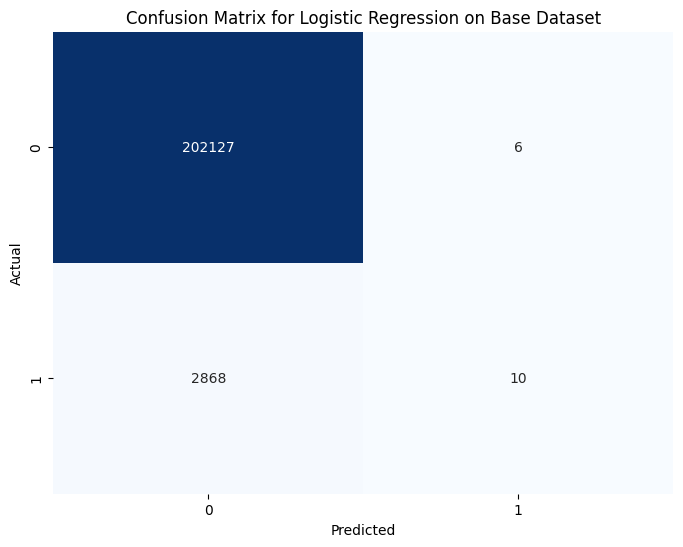

Classification Report for Logistic Regression on Base Dataset:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    202133
           1       0.62      0.00      0.01      2878

    accuracy                           0.99    205011
   macro avg       0.81      0.50      0.50    205011
weighted avg       0.98      0.99      0.98    205011

ROC-AUC Score for Logistic Regression on Base Dataset: 0.88
Training and Evaluating KNN on Base dataset...


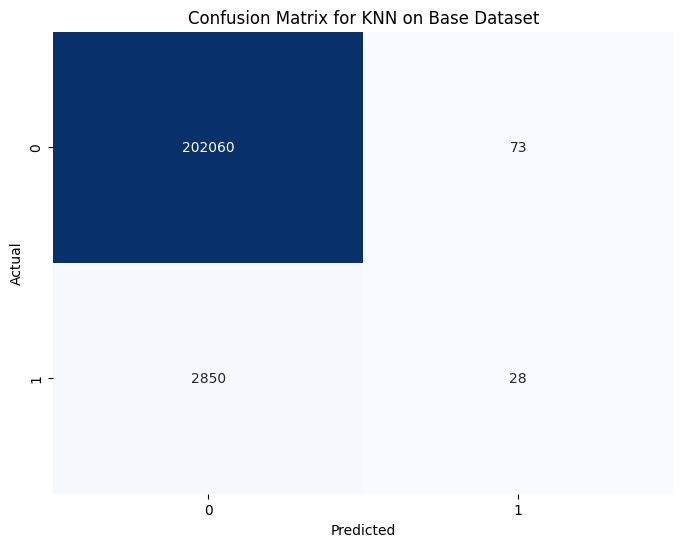

Classification Report for KNN on Base Dataset:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    202133
           1       0.28      0.01      0.02      2878

    accuracy                           0.99    205011
   macro avg       0.63      0.50      0.51    205011
weighted avg       0.98      0.99      0.98    205011

ROC-AUC Score for KNN on Base Dataset: 0.59
Training and Evaluating Random Forest on Base dataset...


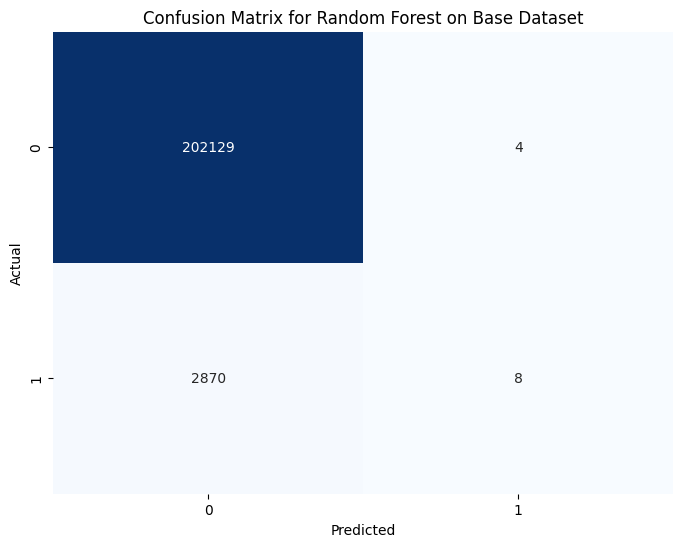

Classification Report for Random Forest on Base Dataset:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    202133
           1       0.67      0.00      0.01      2878

    accuracy                           0.99    205011
   macro avg       0.83      0.50      0.50    205011
weighted avg       0.98      0.99      0.98    205011

ROC-AUC Score for Random Forest on Base Dataset: 0.83
Training and Evaluating Naive Bayes on Base dataset...


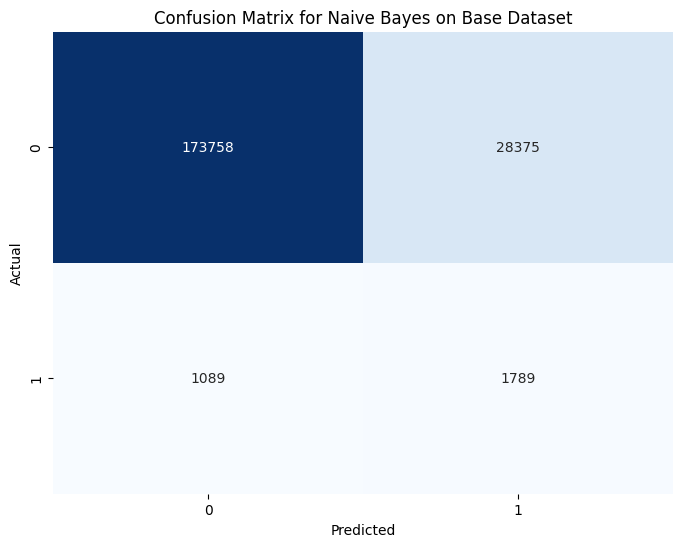

Classification Report for Naive Bayes on Base Dataset:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92    202133
           1       0.06      0.62      0.11      2878

    accuracy                           0.86    205011
   macro avg       0.53      0.74      0.52    205011
weighted avg       0.98      0.86      0.91    205011

ROC-AUC Score for Naive Bayes on Base Dataset: 0.82
Training and Evaluating Logistic Regression on Variant I dataset...


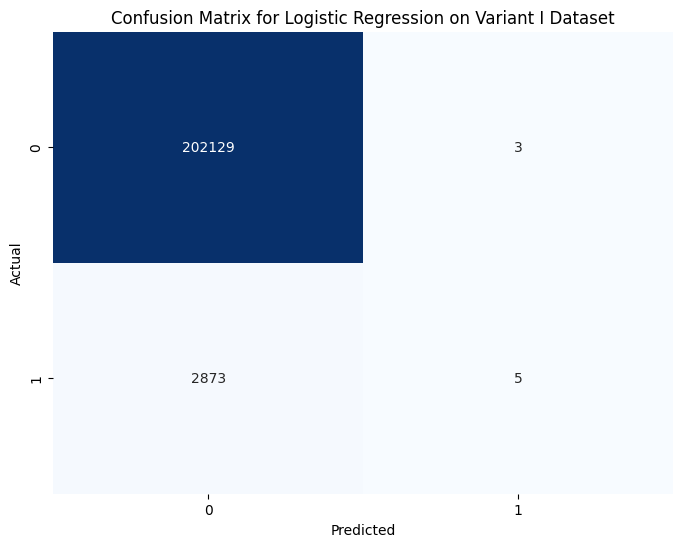

Classification Report for Logistic Regression on Variant I Dataset:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    202132
           1       0.62      0.00      0.00      2878

    accuracy                           0.99    205010
   macro avg       0.81      0.50      0.50    205010
weighted avg       0.98      0.99      0.98    205010

ROC-AUC Score for Logistic Regression on Variant I Dataset: 0.86
Training and Evaluating KNN on Variant I dataset...


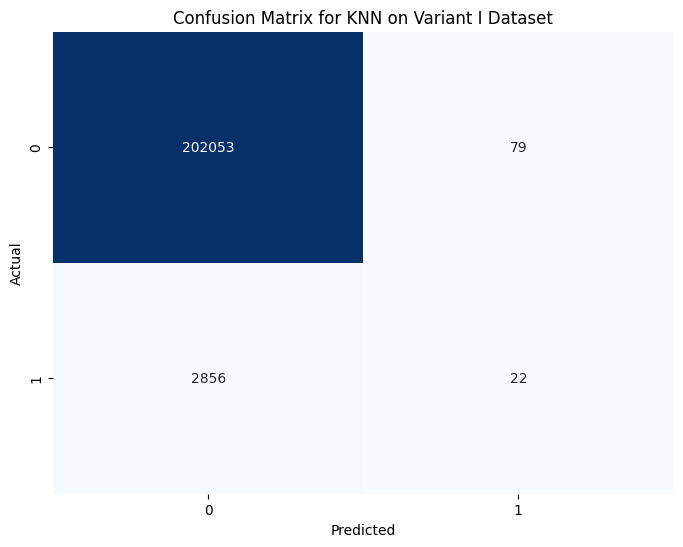

Classification Report for KNN on Variant I Dataset:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    202132
           1       0.22      0.01      0.01      2878

    accuracy                           0.99    205010
   macro avg       0.60      0.50      0.50    205010
weighted avg       0.98      0.99      0.98    205010

ROC-AUC Score for KNN on Variant I Dataset: 0.59
Training and Evaluating Random Forest on Variant I dataset...


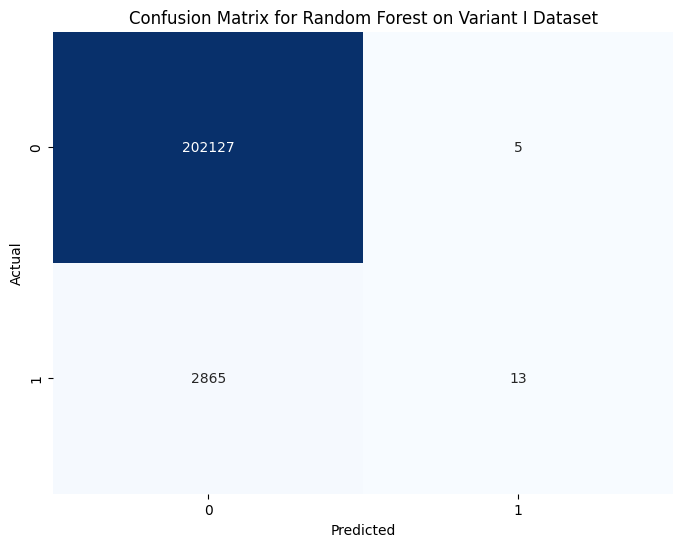

Classification Report for Random Forest on Variant I Dataset:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    202132
           1       0.72      0.00      0.01      2878

    accuracy                           0.99    205010
   macro avg       0.85      0.50      0.50    205010
weighted avg       0.98      0.99      0.98    205010

ROC-AUC Score for Random Forest on Variant I Dataset: 0.82
Training and Evaluating Naive Bayes on Variant I dataset...


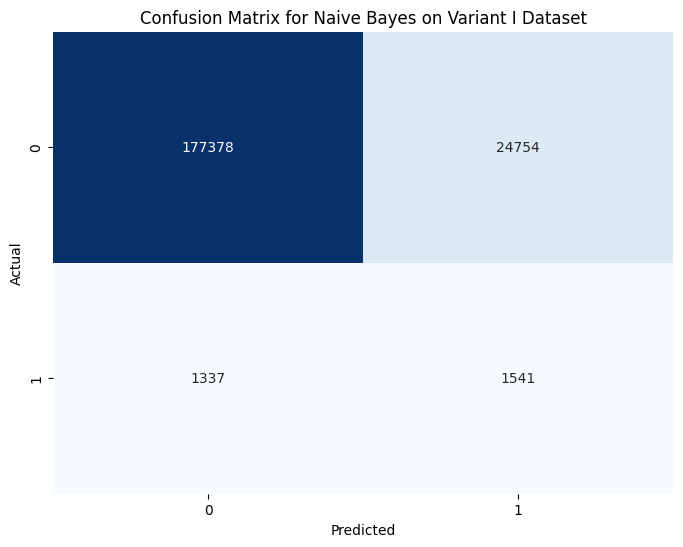

Classification Report for Naive Bayes on Variant I Dataset:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    202132
           1       0.06      0.54      0.11      2878

    accuracy                           0.87    205010
   macro avg       0.53      0.71      0.52    205010
weighted avg       0.98      0.87      0.92    205010

ROC-AUC Score for Naive Bayes on Variant I Dataset: 0.80
Training and Evaluating Logistic Regression on Variant II dataset...


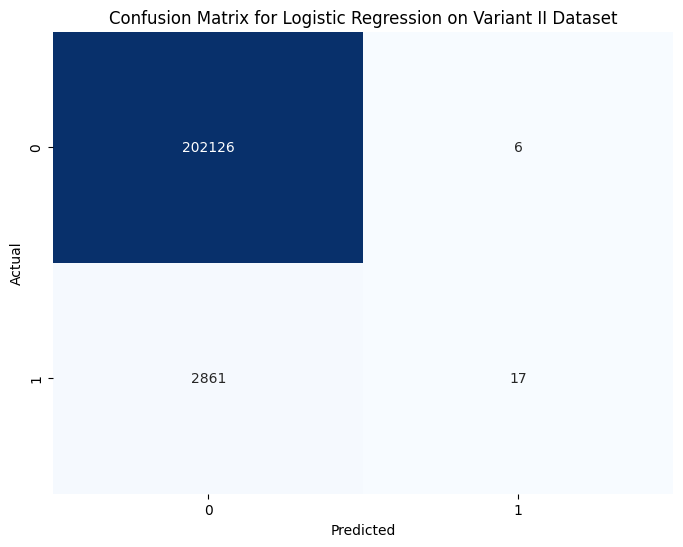

Classification Report for Logistic Regression on Variant II Dataset:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    202132
           1       0.74      0.01      0.01      2878

    accuracy                           0.99    205010
   macro avg       0.86      0.50      0.50    205010
weighted avg       0.98      0.99      0.98    205010

ROC-AUC Score for Logistic Regression on Variant II Dataset: 0.88
Training and Evaluating KNN on Variant II dataset...


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# Lists to store test and bias results
all_metrics_results = []
bias_metrics_results = []

# Iterate through each dataset and model to test them
for dataset_name, data in train_test_data.items():
    for model_name, model in models.items():
        print(f"Training and Evaluating {model_name} on {dataset_name} dataset...")

        # Train the model
        model.fit(data['X_train'], data['y_train'])  # Train on the resampled training data

        # Make predictions
        y_test_pred = model.predict(data['X_test'])
        y_test_prob = model.predict_proba(data['X_test'])[:, 1] if hasattr(model, "predict_proba") else None
        
        # Calculate metrics
        cm = confusion_matrix(data['y_test'], y_test_pred)
        report = classification_report(data['y_test'], y_test_pred, output_dict=True)
        roc_auc = roc_auc_score(data['y_test'], y_test_prob) if y_test_prob is not None else 'N/A'

        # Print Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix for {model_name} on {dataset_name} Dataset")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # Print Classification Report and ROC-AUC
        print(f"Classification Report for {model_name} on {dataset_name} Dataset:")
        print(classification_report(data['y_test'], y_test_pred))
        if y_test_prob is not None:
            print(f"ROC-AUC Score for {model_name} on {dataset_name} Dataset: {roc_auc:.2f}")
        else:
            print(f"ROC-AUC Score for {model_name} on {dataset_name} Dataset: Not Applicable")

        # Calculate performance metrics
        accuracy = accuracy_score(data['y_test'], y_test_pred)
        f1 = f1_score(data['y_test'], y_test_pred)
        roc_auc = roc_auc_score(data['y_test'], y_test_prob) if y_test_prob is not None else 'N/A'

        # Fairness metrics evaluation
        sensitive_attribute = 'employment_status'
        if sensitive_attribute not in data['X_test_raw'].columns:
            raise ValueError(f"'{sensitive_attribute}' column not found in {dataset_name} dataset for bias evaluation.")

        sensitive_features = data['X_test_raw'][sensitive_attribute]

        # Calculate Demographic Parity Difference
        dp_diff = demographic_parity_difference(data['y_test'], y_test_pred, sensitive_features=sensitive_features)

        # Calculate Equalized Odds Difference
        eo_diff = equalized_odds_difference(data['y_test'], y_test_pred, sensitive_features=sensitive_features)

        # Store all metrics results
        all_metrics_results.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'ROC-AUC Score': roc_auc,
            'Demographic Parity Difference': dp_diff,
            'Equalized Odds Difference': eo_diff
        })

        # Store bias metrics separately for plotting
        bias_metrics_results.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'Demographic Parity Difference': dp_diff,
            'Equalized Odds Difference': eo_diff
        })

# Convert all metrics results to DataFrame for visualization
all_metrics_df = pd.DataFrame(all_metrics_results)
bias_summary = pd.DataFrame(bias_metrics_results)

# Print All Metrics Summary
print("\nAll Metrics Summary:")
print(all_metrics_df)

# Plotting All Metrics Summary
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Plot Accuracy for all datasets and models
sns.barplot(data=all_metrics_df, x='Dataset', y='Accuracy', hue='Model', ax=axs[0], palette='viridis')
axs[0].set_title('Accuracy by Dataset and Model')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Dataset')
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y')

# Plot F1 Score for all datasets and models
sns.barplot(data=all_metrics_df, x='Dataset', y='F1 Score', hue='Model', ax=axs[1], palette='magma')
axs[1].set_title('F1 Score by Dataset and Model')
axs[1].set_ylabel('F1 Score')
axs[1].set_xlabel('Dataset')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y')

# Plot ROC-AUC Score for all datasets and models (if applicable)
sns.barplot(data=all_metrics_df[all_metrics_df['ROC-AUC Score'] != 'N/A'], x='Dataset', y='ROC-AUC Score', hue='Model', ax=axs[2], palette='plasma')
axs[2].set_title('ROC-AUC Score by Dataset and Model')
axs[2].set_ylabel('ROC-AUC Score')
axs[2].set_xlabel('Dataset')
axs[2].tick_params(axis='x', rotation=45)
axs[2].grid(axis='y')

plt.tight_layout()
plt.show()

# Plotting Bias Metrics
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Plot Demographic Parity Difference for all datasets and models
sns.barplot(data=bias_summary, x='Dataset', y='Demographic Parity Difference', hue='Model', ax=axs[0], palette='Blues')
axs[0].set_title('Demographic Parity Difference by Dataset and Model')
axs[0].set_ylabel('Demographic Parity Difference')
axs[0].set_xlabel('Dataset')
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y')

# Plot Equalized Odds Difference for all datasets and models
sns.barplot(data=bias_summary, x='Dataset', y='Equalized Odds Difference', hue='Model', ax=axs[1], palette='Greens')
axs[1].set_title('Equalized Odds Difference by Dataset and Model')
axs[1].set_ylabel('Equalized Odds Difference')
axs[1].set_xlabel('Dataset')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()
